# Introduction to Machine Learning

## Section 4.2.0: Predicting Bostom Census Tract Median House Prices

### 13th August, 2021

Lets load in the libraries that we'll need up top:

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Lets first load in infamous the 'Boston Housing Dataset':

In [2]:
data_path = os.path.join(os.getcwd(), '..', 'data')
boston_data = pd.read_csv(os.path.join(data_path, 'boston.txt'), sep='\t')
boston_data.head(5)

,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,LON,LAT,TOWN
0,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,-70.955,42.2550,Nahant
1,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,-70.950,42.2875,Swampscott
2,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,-70.936,42.2830,Swampscott
3,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,-70.928,42.2930,Marblehead
4,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,-70.922,42.2980,Marblehead


Subset for only the columns we're going to use for building our model:

In [3]:
boston_data = boston_data[['RM', 'LSTAT', 'PTRATIO', 'CMEDV']]

Lets do quickly do some very basic Exploratory Data Visualisation ('EDA')

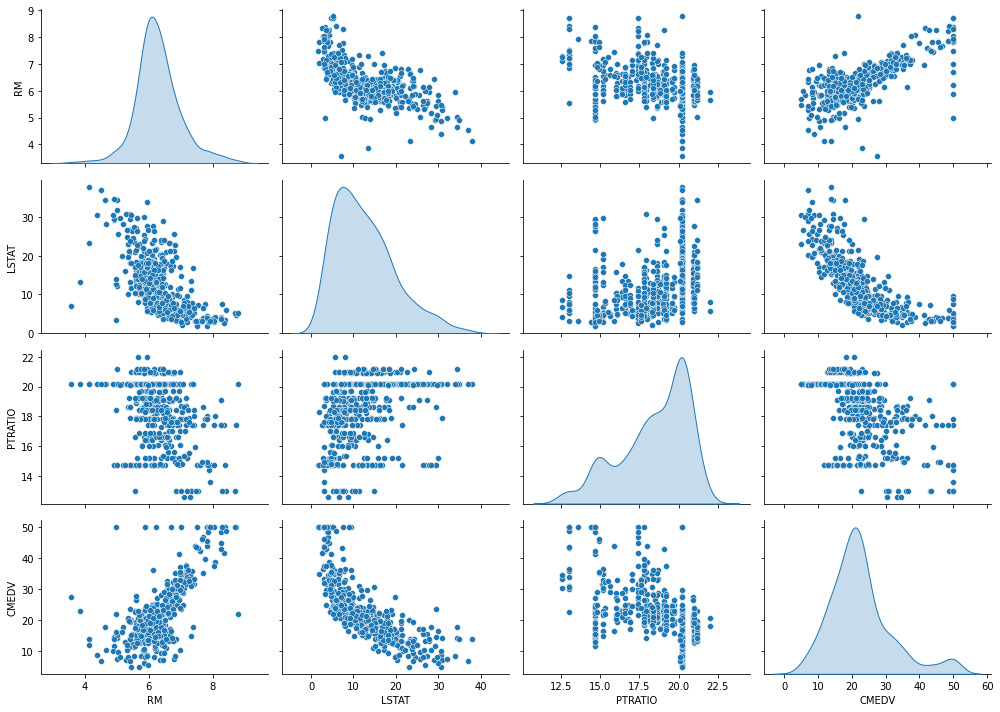

In [4]:
sns.pairplot(boston_data, diag_kind="kde")
fig = plt.gcf()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), '..', 'figures', 'boston_describe.png'),
            dpi=400, facecolor='w', edgecolor='w')

Now, lets engineer one of our features, called 'PTRATIO': the parent teacher ratio in the census tract.

In [5]:
boston_data['PTRATIO_low'] = np.where(boston_data['PTRATIO']<16, 1, 0)
boston_data['PTRATIO_medium'] = np.where((boston_data['PTRATIO']>=16) &
                                         (boston_data['PTRATIO']<=20), 1,0)
boston_data['PTRATIO_high'] = np.where(boston_data['PTRATIO']>20,1,0)
boston_data[['PTRATIO','PTRATIO_low','PTRATIO_medium','PTRATIO_high']].head(3)

,PTRATIO,PTRATIO_low,PTRATIO_medium,PTRATIO_high
0,15.3,1,0,0
1,17.8,0,1,0
2,17.8,0,1,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(boston_data,
                                                    boston_data[['CMEDV']],
                                                    test_size=0.2,
                                                    random_state=10)

Lets now print out some simple descriptive statistics pertaining to our training and test sets:

In [7]:
print('Number of obs in Boston Dataset: ' +
      str(boston_data.shape[0]))
print('Number of obs in training set: ' + str(float(X_train.shape[0])) + ' (' + 
      str(round(float(X_train.shape[0]) /
                float(boston_data.shape[0]),2)*100) + '%)')
print('Number of obs in test set: ' + str(float(X_test.shape[0])) + ' (' + 
      str(round(float(X_test.shape[0]) /
                float(boston_data.shape[0]),2)*100) + '%)')
print('Average median value in the training set: ' + str(round(float(y_train['CMEDV'].mean()), 2)))
print('Average median value in the test set: ' + str(round(float(y_test['CMEDV'].mean()), 2)))

Number of obs in Boston Dataset: 506
Number of obs in training set: 404.0 (80.0%)
Number of obs in test set: 102.0 (20.0%)
Average median value in the training set: 21.86
Average median value in the test set: 25.18


Lets now define a simple model which _doesnt_ bin the `PTRATIO` variable:

In [8]:
regr = linear_model.LinearRegression()
regr.fit(X_train[['RM','LSTAT','PTRATIO']], y_train)
y_pred = regr.predict(X_test[['RM','LSTAT','PTRATIO']])
print("Mean squared error of nobins model: %.2f" %
      mean_squared_error(y_test, y_pred))
print('Variance score of nobins model: %.2f' %
      r2_score(y_test, y_pred))

Mean squared error of nobins model: 35.32
Variance score of nobins model: 0.66


Lets now define a simple model which _does_ bin the PTRATIO variable:

In [9]:
regr.fit(X_train.drop(columns=['PTRATIO','CMEDV']), y_train)
y_pred = regr.predict(X_test.drop(columns=['PTRATIO','CMEDV']))
print("Mean squared error of binned model: %.2f" %
      mean_squared_error(y_test, y_pred))
print('Variance score of binned model: %.2f' %
      r2_score(y_test, y_pred))

Mean squared error of binned model: 35.62
Variance score of binned model: 0.66


Lets now undertake a more elaborate CV type of design where we randomly split our data 25 times (k=25 in a k-fold CV) with two models. The first is only contains `RM`, `LSTAT`, `PTRATIO`. The second contains  `RM`, `LSTAT`, `PTRATIO_low`, `PTRATIO_medium`, `PTRATIO_high`.

In [10]:
kf = KFold(n_splits=50, shuffle=True)
x_nobins = boston_data[['RM','LSTAT','PTRATIO']]
x_binned = boston_data.drop(columns=['PTRATIO', 'CMEDV'])
y = boston_data['CMEDV']
rmse_small = []
rmse_big = []
for train_index, test_index in kf.split(x_nobins):
    regr = linear_model.LinearRegression()
    X_train_small, X_test_small = x_nobins[x_nobins.index.isin(train_index)],\
                                  x_nobins[x_nobins.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)],\
                      y[y.index.isin(test_index)]
    regr.fit(X_train_small,  y_train)
    y_pred_small = regr.predict(X_test_small)
    rmse_small.append(mean_squared_error(y_test, y_pred_small))
    regr = linear_model.LinearRegression()
    X_train_big, X_test_big = x_binned[x_binned.index.isin(train_index)],\
                              x_binned[x_binned.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)],\
                        y[y.index.isin(test_index)]
    regr.fit(X_train_big, y_train)
    y_pred_big = regr.predict(X_test_big)
    rmse_big.append(mean_squared_error(y_test, y_pred_big))

Which feature set performs better? Lets take the average of these 25 splits and calculate the mean RSME from each:

In [11]:
print(np.mean(rmse_big))
print(np.mean(rmse_small))

27.9812187375453
27.546438976356626


Again, we can see that this 'smaller' model _without_ binning PTRATIO performs slightly better. What happens when we visualise this?

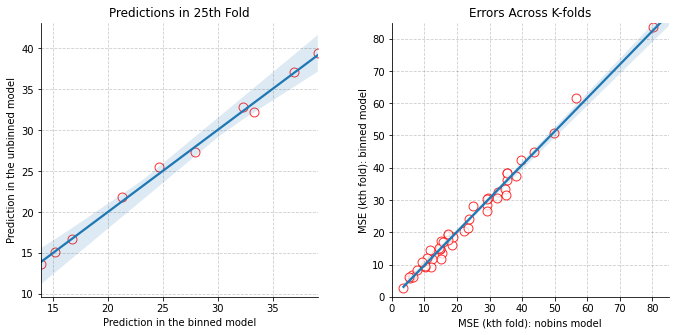

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ee = sns.regplot(y=y_pred_big,x=y_pred_small,ax=ax1, ci=99.999,
                 scatter_kws={'s':80, 'edgecolor':'r', 'color':'w'})
ff = sns.regplot(x=rmse_small, y=rmse_big, ax=ax2, ci=99.999,
                 scatter_kws={'s':80, 'edgecolor':'r', 'color':'w'})
ax1.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
ax1.set_xlabel('Prediction in the binned model')
ax1.set_ylabel('Prediction in the unbinned model')
ax1.set_title('Predictions in 25th Fold')
ax2.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
ax2.set_xlabel('MSE (kth fold): nobins model')
ax2.set_ylim(0,85)
ax2.set_xlim(0,85)
ax2.set_ylabel('MSE (kth fold): binned model')
ax2.set_title('Errors Across K-folds')
plt.tight_layout()
sns.despine()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.savefig(os.path.join(os.getcwd(), '..', 'figures', 'cross_validation.png'), dpi=800,
            facecolor='w', edgecolor='w')

Lesson 1: Cross-validation is important: here our conclusions substantively change!

Lesson 2: Feature engineering doesnt _always_ improve model performance (for every fold)!